# Semi-supervised Evaluation 

This is an notebook attempting to evaluate the performance of different sampling algorithms with a low-budget size in a semi-supervised context. During the paper, Flexmatch was used. But due to computational and resource limitations, a different semi-supervised evaluation approach will be taken. 

As such Semi-supervised learning with SimCLRv1 was convienent, due to having a pretrained SimCLRv1 on CIFAR10 and with Resnet18 as a backbone. Furthermore, the semi-supervised can be decomposed into these 2 steps: 

Unsupervised Pretraining:

SimCLRv1 first pretrains a ResNet model using a large amount of unlabeled data.
The framework employs contrastive learning, where positive pairs (augmented versions of the same image) are pulled together in the representation space, while negative pairs (different images) are pushed apart.

Fine-Tuning:

After pretraining, the learned representations are fine-tuned using a small labeled dataset.
A linear classifier is typically trained on top of the frozen representations, or fine-tuning can involve updating both the representations and classifier.


This notebook will be comparing random, TypiClust and TypiclustPlus performances and evaluating them.

# Imports

In [ ]:
import torchvision 
import torch 
import torch.nn as nn
import numpy as np  
from simclr_pretrained.resnet_cifar import resnet18
from typiclust import Typiclust
from typiclustPlus import TypiclustPlus
import matplotlib.pyplot as plt 
import json

torch.manual_seed(0)
torch.cuda.is_available()

True

# Variables & Setup 

In [2]:
DEVICE = torch.device('cuda')
LR = 0.005
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0003 
NESTEROV = True
DATA_DIR = "./datasets"
BUDGET_SIZE = 10 
N_REPS = 10
EPOCHS = 60

In [3]:
# Define CIFAR-10 data transforms with augmentations
transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(size=32),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
    ]) 

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

In [4]:
train_dataset = torchvision.datasets.CIFAR10(
    root=DATA_DIR, 
    train=True, 
    download=True, 
    transform=transform_test)

feat_dataset = torchvision.datasets.CIFAR10(root=DATA_DIR, 
                                            train=True, 
                                            download=True, 
                                            transform=transform_test)

testset = torchvision.datasets.CIFAR10(root=DATA_DIR, 
                                       train=False, 
                                       download=True, 
                                       transform=transform_test)

train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=10, shuffle=False,
            num_workers=0, pin_memory=True, drop_last=False)

feat_loader = torch.utils.data.DataLoader(
    feat_dataset, batch_size=10, shuffle=False,
    num_workers=0, pin_memory=True, drop_last=False
)

test_loader = torch.utils.data.DataLoader(
            testset, batch_size=10, shuffle=False,
            num_workers=0, pin_memory=True, drop_last=False)

In [5]:
def init_simclr():
    """Initalise Resnet18 for fully-supervised AL"""

    # Load SimCLR Resnet18 model backbone 
    pt_model = resnet18()["backbone"]

    # Load Pre-train SimCLR 
    state_dict = torch.load("simclr_pretrained/simclr_cifar-10.pth")
    new_state_dict = {}

    # Remove projection head from pre-trained weights
    for key, value in state_dict.items():
        # Reformat 
        if key.startswith("backbone."):
            new_key = key.replace("backbone.", "")
            new_state_dict[new_key] = value
        # Ignore projection head 
        if key.startswith("contrastive_head."):
            continue
    
    # Apply pre-trained backbone weights to resnet18 
    pt_model.load_state_dict(new_state_dict,strict=True)

    model = nn.Sequential(pt_model, nn.Linear(512, 10))
    model.to(DEVICE)

    # SGD 
    optimizer = torch.optim.SGD(model.parameters(),
                                lr=LR,
                                momentum=MOMENTUM,
                                weight_decay=WEIGHT_DECAY,
                                nesterov=NESTEROV)
    
    # Cosine scheduler
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200) 

    criterion = nn.CrossEntropyLoss()

    return model, optimizer, scheduler, criterion

def accuracy(outputs: torch.Tensor, labels: torch.Tensor) -> float:
    """Compute accuracy for resnet given outputs as logits"""
    preds = torch.argmax(outputs, dim=1)
    return torch.sum(preds == labels) / len(preds)

def train(model, optimizer, scheduler, criterion, data_loader, epochs):
    """Train resnet18"""
    device = DEVICE
    model.train()  # set model to train

    train_accuracies = []

    for epoch in range(epochs):
        # loss tracking metrics
        running_acc = 0.0

        for i, (inputs, labels) in enumerate(data_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            # zero gradients for every batch
            optimizer.zero_grad()

            # compute predictions + loss
            outputs = model(inputs)  # predicted class
            loss = criterion(outputs, labels)

            # compute training accuracy
            running_acc += accuracy(outputs, labels)

            # perform backpropagation
            loss.backward()  # compute gradients
            optimizer.step()  # update model parameters

        scheduler.step()

        # Train Accuracy 
        train_accuracy = (running_acc / len(data_loader)).item()
        train_accuracies.append((epoch, train_accuracy))
    return train_accuracies

def eval(model, test_loader, criterion):
    """Evaluate model on CIFAR10 validation set"""
    running_vloss = 0.0
    device = DEVICE
    model.eval()  # set model to evaluation

    with torch.no_grad():
        running_val_acc = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_vloss += loss.item()
            # compute validtion accuracy
            running_val_acc += accuracy(outputs, labels)

    val_accuracy = (running_val_acc / len(test_loader)).item()
    avg_vloss = (running_vloss / len(test_loader))
    
    print(f"Val acc: {round(val_accuracy*100, 2)}% | Avg Val Loss: {round(avg_vloss, 4)}")
    return [val_accuracy, avg_vloss]

# Random

In [6]:
def random_sampling(dataset, budget_size, l_set_indices):
    """
    Random sampling 
    
    Args: 
    dataset (torchvision.datasets): CIFAR10 training dataset 
    budget_size (int): sample size 
    l_set_indices List[int]: labelled data points indices 

    Returns: 
    l_set (torch.utils.data.Subset) : Labelled dataset 
    l_set_indices List[int]: Updated labelled data points indices 
    """
    
    tempIdx = [i for i in range(len(dataset))]
    ids = list(set(tempIdx) - set(l_set_indices))
    np.random.shuffle(ids)

    l_set_indices+= ids[0:budget_size]

    l_set = torch.utils.data.Subset(dataset,  l_set_indices)
    return l_set, l_set_indices

In [7]:
def random_finetune_eval(budget_size, epochs):
    l_set_indices = []

    print("---Selecting random examples --")
    l_set, l_set_indices = random_sampling(train_dataset, budget_size, l_set_indices)

    print("--Loading pre-trained simclr model--")
    model, optimizer, scheduler, criterion = init_simclr()

    train_loader = torch.utils.data.DataLoader(
            l_set, batch_size=4096, shuffle=True,
            num_workers=0, pin_memory=True, drop_last=False)
    
    train_results = {}
    val_results = {}

    print("--Training...--")

    train_accuracies = train(model=model, 
            optimizer=optimizer, 
            criterion=criterion, 
            scheduler=scheduler,
            data_loader=train_loader,
            epochs=epochs)
    
    print("--Validating--")
        
    val_accuracies = eval(model, 
                            test_loader, 
                            criterion=criterion, 
                            )
    val_results[f'val iter acc/loss'] = val_accuracies
    train_results[f'train iter acc'] = train_accuracies

    return val_results, train_results


In [8]:
random_results = []
for i in range(N_REPS):
    val_results, train_results = random_finetune_eval(BUDGET_SIZE, EPOCHS)
    random_results.append(val_results)

---Selecting random examples --
--Loading pre-trained simclr model--
--Training...--
--Validating--
Val acc: 15.05% | Avg Val Loss: 2.2991
---Selecting random examples --
--Loading pre-trained simclr model--
--Training...--
--Validating--
Val acc: 17.9% | Avg Val Loss: 2.5196
---Selecting random examples --
--Loading pre-trained simclr model--
--Training...--
--Validating--
Val acc: 27.07% | Avg Val Loss: 2.2757
---Selecting random examples --
--Loading pre-trained simclr model--
--Training...--
--Validating--
Val acc: 24.82% | Avg Val Loss: 2.2087
---Selecting random examples --
--Loading pre-trained simclr model--
--Training...--
--Validating--
Val acc: 13.26% | Avg Val Loss: 2.4637
---Selecting random examples --
--Loading pre-trained simclr model--
--Training...--
--Validating--
Val acc: 13.07% | Avg Val Loss: 2.449
---Selecting random examples --
--Loading pre-trained simclr model--
--Training...--
--Validating--
Val acc: 30.0% | Avg Val Loss: 2.1806
---Selecting random examples -

In [18]:
import json 
out_file = open(f"{DATA_DIR}/random_semi_supervised.json", "w")
json.dump(random_results, out_file, indent = 6)
out_file.close()

# TypiClust

In [24]:
def typi_finetune_eval(budget_size, epochs):
    l_set_indices = []

    args = {
        'data_dir' : './datasets', 
        'dataset_name' : 'cifar10',
        'device' : torch.device('cuda'), #GPU 
        }

    print("---Initial Pooling / L0 Set Extraction--")
    tpc = Typiclust(train_dataset,
                    feat_loader,
                    budget_size,
                    l_set_indices,
                    args)
    
    print(f"Sampling {budget_size} budget")
    l_set, l_set_indices= tpc.sample(l_set_indices=l_set_indices)
    
    print("--Loading pre-trained simclr model--")
    model, optimizer, scheduler, criterion = init_simclr()


    l_set_loader = torch.utils.data.DataLoader(
            l_set, batch_size=10, shuffle=True,
            num_workers=0, pin_memory=True, drop_last=False)
    
    train_results = {}
    val_results = {}

    print("--Training...--")

    train_accuracies = train(model=model, 
            optimizer=optimizer, 
            criterion=criterion, 
            scheduler=scheduler,
            data_loader=l_set_loader,
            epochs=epochs)
    
    print("--Valiating--")
        
    val_accuracies = eval(model, 
                            test_loader, 
                            criterion=criterion, 
                            )
    val_results[f'val iter acc/loss'] = val_accuracies
    train_results[f'train iter acc'] = train_accuracies

    return val_results, train_results

In [26]:
typi_results = []
for i in range(N_REPS):
    val_results, train_results = typi_finetune_eval(BUDGET_SIZE, EPOCHS)
    typi_results.append(val_results)

---Initial Pooling / L0 Set Extraction--
Loaded features in locally
Sampling 10 budget
--Loading pre-trained simclr model--
--Training...--
--Valiating--
Val acc: 32.46% | Avg Val Loss: 2.1014
---Initial Pooling / L0 Set Extraction--
Loaded features in locally
Sampling 10 budget
Loaded typiclust_cifar10_budget_10.npy locally...
--Loading pre-trained simclr model--
--Training...--
--Valiating--
Val acc: 35.25% | Avg Val Loss: 2.0959
---Initial Pooling / L0 Set Extraction--
Loaded features in locally
Sampling 10 budget
Loaded typiclust_cifar10_budget_10.npy locally...
--Loading pre-trained simclr model--
--Training...--
--Valiating--
Val acc: 28.61% | Avg Val Loss: 2.1052
---Initial Pooling / L0 Set Extraction--
Loaded features in locally
Sampling 10 budget
Loaded typiclust_cifar10_budget_10.npy locally...
--Loading pre-trained simclr model--
--Training...--
--Valiating--
Val acc: 31.37% | Avg Val Loss: 2.1012
---Initial Pooling / L0 Set Extraction--
Loaded features in locally
Sampling 1

In [27]:
import json 
out_file = open(f"{DATA_DIR}/typiclust_semi_supervised.json", "w")
json.dump(typi_results, out_file, indent = 6)
out_file.close()

# TypiClust Plus

In [14]:
def typiplus_finetune_eval(budget_size, epochs):
    l_set_indices = []

    args = {
        'data_dir' : './datasets', 
        'dataset_name' : 'cifar10',
        'device' : torch.device('cuda'), #GPU 
        }

    print("---Initial Pooling / L0 Set Extraction--")
    tpc = TypiclustPlus(train_dataset,
                    feat_loader,
                    budget_size,
                    l_set_indices,
                    args)
    
    print(f"Sampling {budget_size} budget")
    l_set, l_set_indices= tpc.sample(l_set_indices=l_set_indices)
    
    print("--Loading pre-trained simclr model--")
    model, optimizer, scheduler, criterion = init_simclr()


    l_set_loader = torch.utils.data.DataLoader(
            l_set, batch_size=10, shuffle=True,
            num_workers=0, pin_memory=True, drop_last=False)
    
    train_results = {}
    val_results = {}

    print("--Training...--")

    train_accuracies = train(model=model, 
            optimizer=optimizer, 
            criterion=criterion, 
            scheduler=scheduler,
            data_loader=l_set_loader,
            epochs=epochs)
    
    print("--Valiating--")
        
    val_accuracies = eval(model, 
                            test_loader, 
                            criterion=criterion, 
                            )
    val_results[f'val iter acc/loss'] = val_accuracies
    train_results[f'train iter acc'] = train_accuracies

    return val_results, train_results

In [15]:
typiplus_results = []
for i in range(N_REPS):
    val_results, train_results = typiplus_finetune_eval(BUDGET_SIZE, EPOCHS)
    typiplus_results.append(val_results)

---Initial Pooling / L0 Set Extraction--
Loaded features in locally
Sampling 10 budget
Loaded typiclustplus_cifar10_budget_10.npy locally...
--Loading pre-trained simclr model--
--Training...--
--Valiating--
Val acc: 30.65% | Avg Val Loss: 2.1284
---Initial Pooling / L0 Set Extraction--
Loaded features in locally
Sampling 10 budget
Loaded typiclustplus_cifar10_budget_10.npy locally...
--Loading pre-trained simclr model--
--Training...--
--Valiating--
Val acc: 26.8% | Avg Val Loss: 2.1605
---Initial Pooling / L0 Set Extraction--
Loaded features in locally
Sampling 10 budget
Loaded typiclustplus_cifar10_budget_10.npy locally...
--Loading pre-trained simclr model--
--Training...--
--Valiating--
Val acc: 33.66% | Avg Val Loss: 2.1214
---Initial Pooling / L0 Set Extraction--
Loaded features in locally
Sampling 10 budget
Loaded typiclustplus_cifar10_budget_10.npy locally...
--Loading pre-trained simclr model--
--Training...--
--Valiating--
Val acc: 33.8% | Avg Val Loss: 2.1306
---Initial Poo

In [16]:
out_file = open(f"{DATA_DIR}/typiclustplus_semi_supervised.json", "w")
json.dump(typi_results, out_file, indent = 6)
out_file.close()

# Plot 

In [28]:
# OPTIONAL 
f = open(f"{DATA_DIR}/typiclustplus_semi_supervised.json")
typiplus_results = json.load(f)

f = open(f"{DATA_DIR}/random_semi_supervised.json")
random_results = json.load(f)

f = open(f"{DATA_DIR}/typiclust_semi_supervised.json")
typi_results = json.load(f)

In [29]:
from scipy import stats
import scikit_posthocs

a = 0.05

sample_results = [typi_results, typiplus_results, random_results]
sample_results = [np.array([v['val iter acc/loss'][0]*100 for v in r]) for r in sample_results]

means = [round(float(np.mean(r)),2) for r in sample_results]
std = [round(float(np.std(r)),2) for r in sample_results]

# Statistical Analysis 
print(f"Kruskal-Wallis P-value test w/ Post hoc\nSig level:{a}")
print("---------")
print(f"Budget 10 P-Value: {(stats.kruskal(sample_results[0],
                                           sample_results[1],
                                           sample_results[2])[-1])}\n")

post_hoc = scikit_posthocs.posthoc_dunn(sample_results)
print("Post hoc Dunn's test")
print(post_hoc)
print('\n\n')

Kruskal-Wallis P-value test w/ Post hoc
Sig level:0.05
---------
Budget 10 P-Value: 9.814860893089366e-06

Post hoc Dunn's test
          1         2         3
1  1.000000  0.022254  0.011917
2  0.022254  1.000000  0.000002
3  0.011917  0.000002  1.000000





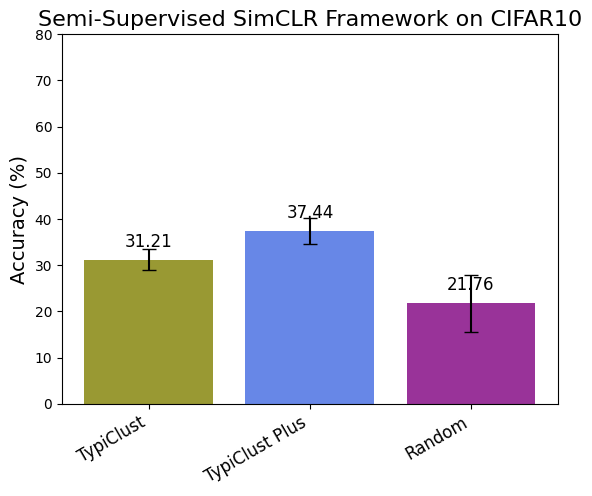

In [30]:
# Categories
categories = ['TypiClust', 'TypiClust Plus', 'Random']

# Colors for bars
colors = ['olive', 'royalblue', 'purple']

# Create figure and axis
fig, ax = plt.subplots()

# Plot bars with error bars
bars = ax.bar(categories, means, yerr=std, capsize=5, color=colors, alpha=0.8)

# Annotate bars with values
for bar, mean in zip(bars, means):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 2, f'{mean}', 
            ha='center', va='bottom', fontsize=12)

# Labels and formatting
ax.set_ylabel("Accuracy (%)", fontsize=14)
ax.set_ylim(0, 80)
ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories, rotation=30, ha="right", fontsize=12)
plt.title('Semi-Supervised SimCLR Framework on CIFAR10', fontsize=16)

# Show plot
plt.show()